# Random forest feature selection

This notebook implements random forest classification for feature selection processes on the dropout-filtered data.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'sans-serif',
        'size'   : 15}
matplotlib.rc('font', **font)

In [2]:
df1 = pd.read_csv("df_nonzero_means.csv", sep="\t")
genenames = df1.iloc[:,0].values
df1 = df1.drop('geneID', axis=1)
colnames = df1.columns
ngenes = len(df1)
nconds = len(colnames)
cell_type = pd.Series(0, index=np.arange(nconds), name='phenotype')

for index, colname in enumerate(colnames):
    if "NSen" in colname:
        cell_type.iloc[index] = 0
    else:
        cell_type.iloc[index] = 1
    if "Sen" not in colname:
        cell_type.iloc[index] = 0

df = df1.T
df.columns = genenames

In [3]:
lut = pd.read_csv("geneID_ens_symbol.csv", sep="\t")
lut = lut.drop('Unnamed: 0', axis=1)

In [4]:
rseed = 15
topn = 200
ecfs_genes = ['Fabp3','Lncpint','Pcnp','Luc7l3','AI427809','Cd59a']
ecfs_ids = []
for i, egene in enumerate(ecfs_genes):
    ecfs_ids.append(lut[lut['symbol']==egene]['ensID'].to_string(index=False))

X_train = df.to_numpy()
y_train = cell_type.to_numpy()

common_genes = []
common_genes_control = []
old_features = []
coincidences = []
for i in range(1000):
    # Train the Random Forest model
    rf = RandomForestClassifier(n_estimators=100, random_state=rseed)
    rf.fit(X_train, y_train)

    # Extract feature importances
    importances = rf.feature_importances_
    feature_names = df.columns
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

    # Rank features by importance
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    top_features = feature_importance_df['Feature'][:topn].to_numpy()
    coincidences.append(len(np.intersect1d(top_features, old_features)))
    randlist = np.random.choice(range(ngenes), size=topn, replace=False)
    random_features = feature_importance_df['Feature'][randlist].to_numpy()

    common_genes_1 = len(list(set(ecfs_ids) & set(top_features)))
    common_genes_control_1 = len(list(set(ecfs_ids) & set(random_features)))
    common_genes.append(common_genes_1)
    common_genes_control.append(common_genes_control_1)
    old_features = top_features
    rseed = rseed+1


/var/folders/_9/wrcz_pbx7m9b5_xk48rtg12w0000gn/T/ipykernel_41472/1296491064.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


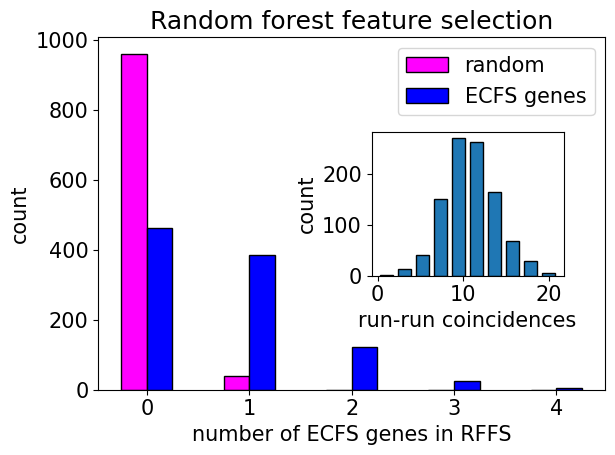

In [5]:
common_all = [common_genes_control,common_genes,]
colors = ['magenta','blue']
labels = ['random', 'ECFS genes']
n_bins = max(common_genes)+1

fig, ax1 = plt.subplots()

# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.6, 0.4, 0.3, 0.3]
ax2 = fig.add_axes([left, bottom, width, height])

ax2.hist(coincidences, edgecolor='black', rwidth=0.7)
ax2.set_xlabel('run-run coincidences')
ax2.set_ylabel('count')
ax1.hist(common_all, range(min(common_genes), max(common_genes) + 2), color=colors, label=labels, edgecolor='black', rwidth=0.5)
ax1.legend()
ax1.set_xlabel('number of ECFS genes in RFFS')
ax1.set_ylabel('count')
ax1.set_xticks([0.5, 1.5, 2.5, 3.5, 4.5], ['0', '1', '2', '3', '4'])
ax1.set_title('Random forest feature selection')

plt.tight_layout()
plt.savefig('figures/fig_random_forest_dropout.pdf')

plt.show()